In [1]:
# import all modules needed
import models.eda as eda

import pandas as pd
import numpy as np
from IPython.display import display

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.utils import resample

import xgboost as xgb

from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

In [2]:
# load train set
client = eda.load_data("data/train/client_train.csv")
invoice = eda.load_data("data/train/invoice_train.csv")
train = eda.feature_change(client, invoice)


/var/folders/zj/y95dm4bn0jz_s678nqhm92b80000gn/T/ipykernel_4747/1316648785.py:3: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  invoice = eda.load_data("data/train/invoice_train.csv")


In [3]:
train.head()

,district,client_id,client_catg,region,target,region_group,coop_time,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,months_number,counter_type,invoice_month,invoice_year,is_weekday,total_consumption
0,60,0,11,101,0.0,200,288,11,1335667,0,203,8,1,4,1,3,2014,0.0,82
1,60,0,11,101,0.0,200,288,11,1335667,0,203,6,1,4,1,3,2013,0.0,1384
2,60,0,11,101,0.0,200,288,11,1335667,0,203,8,1,4,1,3,2015,0.0,123
3,60,0,11,101,0.0,200,288,11,1335667,0,207,8,1,4,1,7,2015,0.0,102
4,60,0,11,101,0.0,200,288,11,1335667,0,207,9,1,12,1,11,2016,0.0,572


## Baseline model
- our very simple baseline model assumes every client from district 51 is fraudulent. 

In [4]:
def baseline_model(X):
    y_pred = [0 if cat != 51 else 1 for cat in X.client_catg]
    return y_pred

# in district 51 the most fraudulents appear:
pd.crosstab(train['target'], train['client_catg'], normalize='columns')*100

client_catg,11,12,51
target,,,
0.0,92.391486,94.413284,79.044952
1.0,7.608514,5.586716,20.955048


In [5]:
# Select the features to use for modeling
X_train = train.drop("target", axis=1)
y_train = train.target
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

y_pred = baseline_model(X_test)

print('F1-score:', precision_score(y_test, y_pred).round(2))
print('ROC AUC:', roc_auc_score(y_test, y_pred).round(2))

F1-score: 0.21
ROC AUC: 0.52


## Customized sampling and train test spilt

In [14]:
df_train, df_test = eda.sampled_train_test_split(train)

In [46]:
X_train = df_train.drop("target", axis=1)
X_test = df_test.drop("target", axis=1)
y_train = df_train.target
y_test = df_test.target


1384       1.0
1385       1.0
1386       1.0
1387       1.0
1388       1.0
          ... 
4476230    1.0
4476231    1.0
4476232    1.0
4476233    1.0
4476234    1.0
Name: target, Length: 418059, dtype: float64

## Feature scaling

In [15]:
X_train = eda.get_mean_consumption(X_train)
X_train = eda.get_historical_mean(X_train)
X_test = eda.get_mean_consumption(X_test)
X_test = eda.get_historical_mean(X_test)

## Scaling

In [16]:
# scaling of the data
scaler_down = StandardScaler()
X_train_preprocessed = scaler_down.fit_transform(X_train)
X_test_preprocessed = scaler_down.transform(X_test)

## XGBoost with GridSearch (on customized downsampled dataset)

In [9]:
# Define XGBoost model with enable_categorical=True and tree_method='hist'
xgb_model = xgb.XGBClassifier(objective='binary:logistic', seed=42, enable_categorical=True, tree_method='hist')

# Define parameter grid for grid search
param_grid = {
    'objective': ['binary:logistic'],
    'seed': [42],
    'enable_categorical': [True],
    'tree_method': ['hist'],
    'n_estimators': [400], #[200, 400],
    'max_depth': [30],  #[30, 40, 50],
    'learning_rate': [0.1] # [0.1, 0.01, 1]
}

# Create GridSearchCV object
clf = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit GridSearchCV object to training data
clf.fit(X_train_preprocessed, y_train)

# Predict on test data using best model
y_pred = clf.predict(X_test_preprocessed)

eda.print_metrics(y_test, y_pred)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Accuracy: 0.53
Precision: 0.58
Recall: 0.70
F1 Score: 0.63
ROC AUC Score: 0.49


In [72]:
# eda.print_metrics(y_test, y_pred)
clf.best_params_

{'enable_categorical': True,
 'learning_rate': 0.01,
 'max_depth': 30,
 'n_estimators': 400,
 'objective': 'binary:logistic',
 'seed': 42,
 'tree_method': 'hist'}

In [28]:
# results = pd.concat([X_test, pd.DataFrame(y_pred)], axis=0).groupby("client_id")
X_test["target_pred"] = pd.Series(y_pred)
X_test["target"] = y_test.values.astype(int)


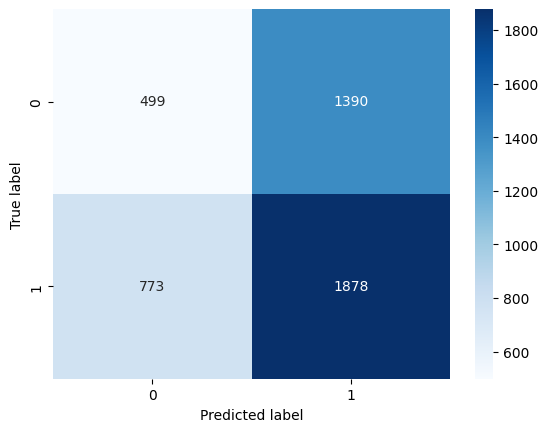

In [40]:
y_pred_client = X_test.groupby("client_id")["target_pred"].mean().to_list()
y_pred_client = [1 if num > 0.5 else 0 for num in y_pred_client]
y_true_client = X_test.groupby("client_id")["target"].mean().to_list()
y_true_client = [1 if num > 0.5 else 0 for num in y_true_client]


# eda.print_metrics(y_test, y_pred)
cm = confusion_matrix(y_true_client, y_pred_client)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [42]:
X_train.head(50)



1384       1.0
1385       1.0
1386       1.0
1387       1.0
1388       1.0
          ... 
4476230    1.0
4476231    1.0
4476232    1.0
4476233    1.0
4476234    1.0
Name: target, Length: 418059, dtype: float64

In [20]:
import pickle

# Save the model to a file
with open('model_xgboost_downsample.pkl', 'wb') as f:
    pickle.dump(clf, f)

# Logistic Regression

In [60]:
# Fit logistic regression model on the training data
lr = LogisticRegression(random_state=42)
lr.fit(X_train_preprocessed, y_train)

# Predict on test data using logistic regression model
y_pred_lr = lr.predict(X_test_preprocessed)

eda.print_metrics(y_test, y_pred_lr)


Accuracy: 0.62
Precision: 0.63
Recall: 0.88
F1 Score: 0.73
ROC AUC Score: 0.56
